<a href="https://colab.research.google.com/github/KamakhyaBansal/rfgannet/blob/main/RfGANGit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

df = pd.read_csv('AllIndiaMonthlyRegional.csv')

continuous_features = [ 'CyclonesinIndia', 'WesternHemisphereWarmPool',
       'OceanNinoIndex', 'ElNinoPrecipitationIndex', 'BivariateENSO',
       'NorthAtlanticOscillation', 'AtlanticSST', 'EastAsia', 'AMO',
       'AtlanticHurricaneDays', 'AntarcticOscillation', 'Rain', 'MeanTemp',
       'Methane', 'Cdioxide', 'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr',
       'msl', 'Region1', 'Region2', 'Region3', 'Region4', 'Region5']
df = df.drop('Date',axis=1)
df = df.fillna(df.mean())
# df[df<0]=0

df.columns


Index(['CyclonesinIndia', 'WesternHemisphereWarmPool', 'OceanNinoIndex',
       'ElNinoPrecipitationIndex', 'BivariateENSO', 'NorthAtlanticOscillation',
       'AtlanticSST', 'EastAsia', 'AMO', 'AtlanticHurricaneDays',
       'AntarcticOscillation', 'Rain', 'MeanTemp', 'Methane', 'Cdioxide',
       'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr', 'msl', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region5'],
      dtype='object')

In [ ]:
# training configuration
noise_dim = 32
dim = 128
batch_size = 32

log_step = 100
epochs = 5000+1
learning_rate = 5e-4
models_dir = 'model'

import numpy as np

for column in continuous_features:
  min = df[column].min()
  max = df[column].max()
  feature_bins = pd.cut(df[column], bins=np.linspace(min, max, 21), labels=False)
  df.drop([column], axis=1, inplace=True)
  df = pd.concat([df, feature_bins], axis=1)
  df[df<0]=0
  df.fillna(df.mean)
  print(column)
  print(feature_bins)

CyclonesinIndia
0      12.0
1       4.0
2       NaN
3      17.0
4       2.0
       ... 
823     3.0
824     0.0
825     NaN
826     NaN
827     0.0
Name: CyclonesinIndia, Length: 828, dtype: float64
WesternHemisphereWarmPool
0       NaN
1       NaN
2       0.0
3       NaN
4       NaN
       ... 
823    11.0
824     9.0
825    12.0
826     7.0
827     2.0
Name: WesternHemisphereWarmPool, Length: 828, dtype: float64
OceanNinoIndex
0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
       ... 
823     2.0
824     2.0
825     3.0
826    10.0
827     6.0
Name: OceanNinoIndex, Length: 828, dtype: float64
ElNinoPrecipitationIndex
0      0.0
1      0.0
2      0.0
3      0.0
4      0.0
      ... 
823    NaN
824    NaN
825    NaN
826    NaN
827    NaN
Name: ElNinoPrecipitationIndex, Length: 828, dtype: float64
BivariateENSO
0      1.0
1      2.0
2      4.0
3      1.0
4      1.0
      ... 
823    NaN
824    NaN
825    NaN
826    NaN
827    NaN
Name: BivariateENSO, Length: 828, dtype: flo

In [ ]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras import Model

from tensorflow.keras.optimizers import Adam

class GAN():
    
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim,
         self.data_dim, layers_dim] = gan_args

        self.generator = Generator(self.batch_size).\
            build_model(input_shape=(self.noise_dim,), dim=layers_dim, data_dim=self.data_dim)

        self.discriminator = Discriminator(self.batch_size).\
            build_model(input_shape=(self.data_dim,), dim=layers_dim)

        optimizer = Adam(lr, 0.5)

        # Build and compile the discriminator
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        # The generator takes noise as input and generates imgs
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)

        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines validity
        validity = self.discriminator(record)

        # The combined model  (stacked generator and discriminator)
        # Trains the generator to fool the discriminator
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

    def get_data_batch(self, train, batch_size, seed=0):
        # # random sampling - some samples will have excessively low or high sampling, but easy to implement
        # np.random.seed(seed)
        # x = train.loc[ np.random.choice(train.index, batch_size) ].values
        # iterate through shuffled indices, so every sample gets covered evenly

        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))  # wasteful to shuffle every time
        train_ix = list(train_ix) + list(train_ix)  # duplicate to cover ranges past the end of the set
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
        
    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        
        data_cols = data.columns

        # Adversarial ground truths
        valid = np.ones((self.batch_size, 1))
        fake = np.zeros((self.batch_size, 1))

        for epoch in range(epochs):    
            # ---------------------
            #  Train Discriminator
            # ---------------------
            batch_data = self.get_data_batch(data, self.batch_size)
            noise = tf.random.normal((self.batch_size, self.noise_dim))

            # Generate a batch of new images
            gen_data = self.generator.predict(noise)
    
            # Train the discriminator
            d_loss_real = self.discriminator.train_on_batch(batch_data, valid)
            d_loss_fake = self.discriminator.train_on_batch(gen_data, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    
            # ---------------------
            #  Train Generator
            # ---------------------
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            # Train the generator (to have the discriminator label samples as valid)
            g_loss = self.combined.train_on_batch(noise, valid)
    
            # Plot the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss))
    
            # If at save interval => save generated events
            if epoch % sample_interval == 0:
                #Test here data generation step
                # save model checkpoints
                model_checkpoint_base_name = 'model/' + cache_prefix + '_{}_model_weights_step_{}.h5'
                self.generator.save_weights(model_checkpoint_base_name.format('generator', epoch))
                self.discriminator.save_weights(model_checkpoint_base_name.format('discriminator', epoch))

                #Here is generating the data
                z = tf.random.normal((432, self.noise_dim))
                gen_data = self.generator(z)
                print('generated_data')

    def save(self, path, name):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        model_path = os.path.join(path, name)
        self.generator.save_weights(model_path)  # Load the generator
        return
    
    def load(self, path):
        assert os.path.isdir(path) == True, \
            "Please provide a valid path. Path must be a directory."
        self.generator = Generator(self.batch_size)
        self.generator = self.generator.load_weights(path)
        return self.generator
    
class Generator():
    def __init__(self, batch_size):
        self.batch_size=batch_size
        
    def build_model(self, input_shape, dim, data_dim):
        input= Input(shape=input_shape, batch_size=self.batch_size)
        # LSTM
        x = tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[26])(input)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(26, return_sequences=True))(x)
        x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(26))(x)
        x = tf.keras.layers.Lambda(lambda y: y * 100.0)(x)
        
        x = Dense(data_dim)(x)
        return Model(inputs=input, outputs=x)

        

class Discriminator():
    def __init__(self,batch_size):
        self.batch_size=batch_size
    
    def build_model(self, input_shape, dim):
        input = Input(shape=input_shape, batch_size=self.batch_size)
        x = Dense(dim * 4, activation='relu')(input)
        x = Dropout(0.1)(x)
        x = Dense(dim * 2, activation='relu')(x)
        x = Dropout(0.1)(x)
        x = Dense(dim, activation='relu')(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(inputs=input, outputs=x)

In [ ]:
data_cols = df.columns
#Define the GAN and training parameters
df[data_cols] = df[data_cols]
df = df.fillna(df.mean())

print(df.shape[1])

gan_args = [batch_size, learning_rate, noise_dim, df.shape[1], dim]
train_args = ['', epochs, log_step]

26


In [ ]:
!mkdir model
!mkdir model/gan
!mkdir model/gan/saved

In [ ]:
model = GAN

#Training the GAN model chosen
synthesizer = model(gan_args)
# Training time
import time
start = time.time()

synthesizer.train(df, train_args)

stop = time.time()
print(f"Training time: {stop - start}sec")

Streaming output truncated to the last 5000 lines.
52 [D loss: 0.532553, acc.: 62.50%] [G loss: 0.865458]
53 [D loss: 0.516110, acc.: 71.88%] [G loss: 0.863080]
54 [D loss: 0.521878, acc.: 64.06%] [G loss: 0.856555]
55 [D loss: 0.574621, acc.: 60.94%] [G loss: 0.815220]
56 [D loss: 0.566155, acc.: 70.31%] [G loss: 0.818527]
57 [D loss: 0.578920, acc.: 59.38%] [G loss: 1.109532]
58 [D loss: 0.584235, acc.: 59.38%] [G loss: 0.868681]
59 [D loss: 0.520659, acc.: 75.00%] [G loss: 0.912563]
60 [D loss: 0.531196, acc.: 68.75%] [G loss: 0.927763]
61 [D loss: 0.614310, acc.: 65.62%] [G loss: 0.889266]
62 [D loss: 0.475157, acc.: 79.69%] [G loss: 0.950238]
63 [D loss: 0.545527, acc.: 64.06%] [G loss: 1.050503]
64 [D loss: 0.469793, acc.: 78.12%] [G loss: 0.942236]
65 [D loss: 0.556628, acc.: 65.62%] [G loss: 0.968333]
66 [D loss: 0.494264, acc.: 78.12%] [G loss: 0.986465]
67 [D loss: 0.486668, acc.: 73.44%] [G loss: 0.984979]
68 [D loss: 0.474597, acc.: 71.88%] [G loss: 0.960533]
69 [D loss: 0.

In [ ]:

synthesizer.save('model/gan/saved', 'generator_India')
# synthesizer.generator.summary()
# synthesizer.discriminator.summary()
models = {'GAN': ['GAN', False, synthesizer.generator]}


In [ ]:
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 512 
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

base_dir = 'model/'

#Actual fraud data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 26

axarr = [[]]*len(model_steps)

# fig = plt.figure(figsize=(14,rows*3))
col_group_by='Rain'

for model_step_ix, model_step in enumerate(model_steps):        
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    # ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z, batch_size=32)

    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    gen_samples.to_csv('Generated_sample.csv')




In [ ]:
!pip install table-evaluator==1.2.2.post1

  Created wheel for table-evaluator: filename=table_evaluator-1.2.2.post1-py3-none-any.whl size=17051 sha256=f42d4a1225e666960a391627a6a53e6e3c4c249fa0fd50681470abcfd40c1687
  Stored in directory: /root/.cache/pip/wheels/45/c7/20/47a3f8b044d705f3c088d9577968a805dded4b83096fabd2ac
Successfully built table-evaluator


Index(['CyclonesinIndia', 'WesternHemisphereWarmPool', 'OceanNinoIndex',
       'ElNinoPrecipitationIndex', 'BivariateENSO', 'NorthAtlanticOscillation',
       'AtlanticSST', 'EastAsia', 'AMO', 'AtlanticHurricaneDays',
       'AntarcticOscillation', 'Rain', 'MeanTemp', 'Methane', 'Cdioxide',
       'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr', 'msl', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region5'],
      dtype='object')
(512, 26) (512, 26)
Index(['CyclonesinIndia', 'WesternHemisphereWarmPool', 'OceanNinoIndex',
       'ElNinoPrecipitationIndex', 'BivariateENSO', 'NorthAtlanticOscillation',
       'AtlanticSST', 'EastAsia', 'AMO', 'AtlanticHurricaneDays',
       'AntarcticOscillation', 'Rain', 'MeanTemp', 'Methane', 'Cdioxide',
       'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr', 'msl', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region5'],
      dtype='object')


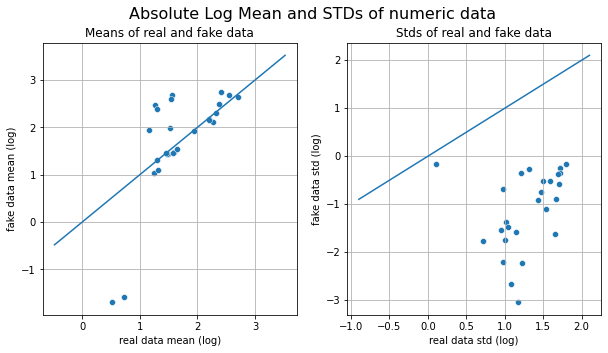

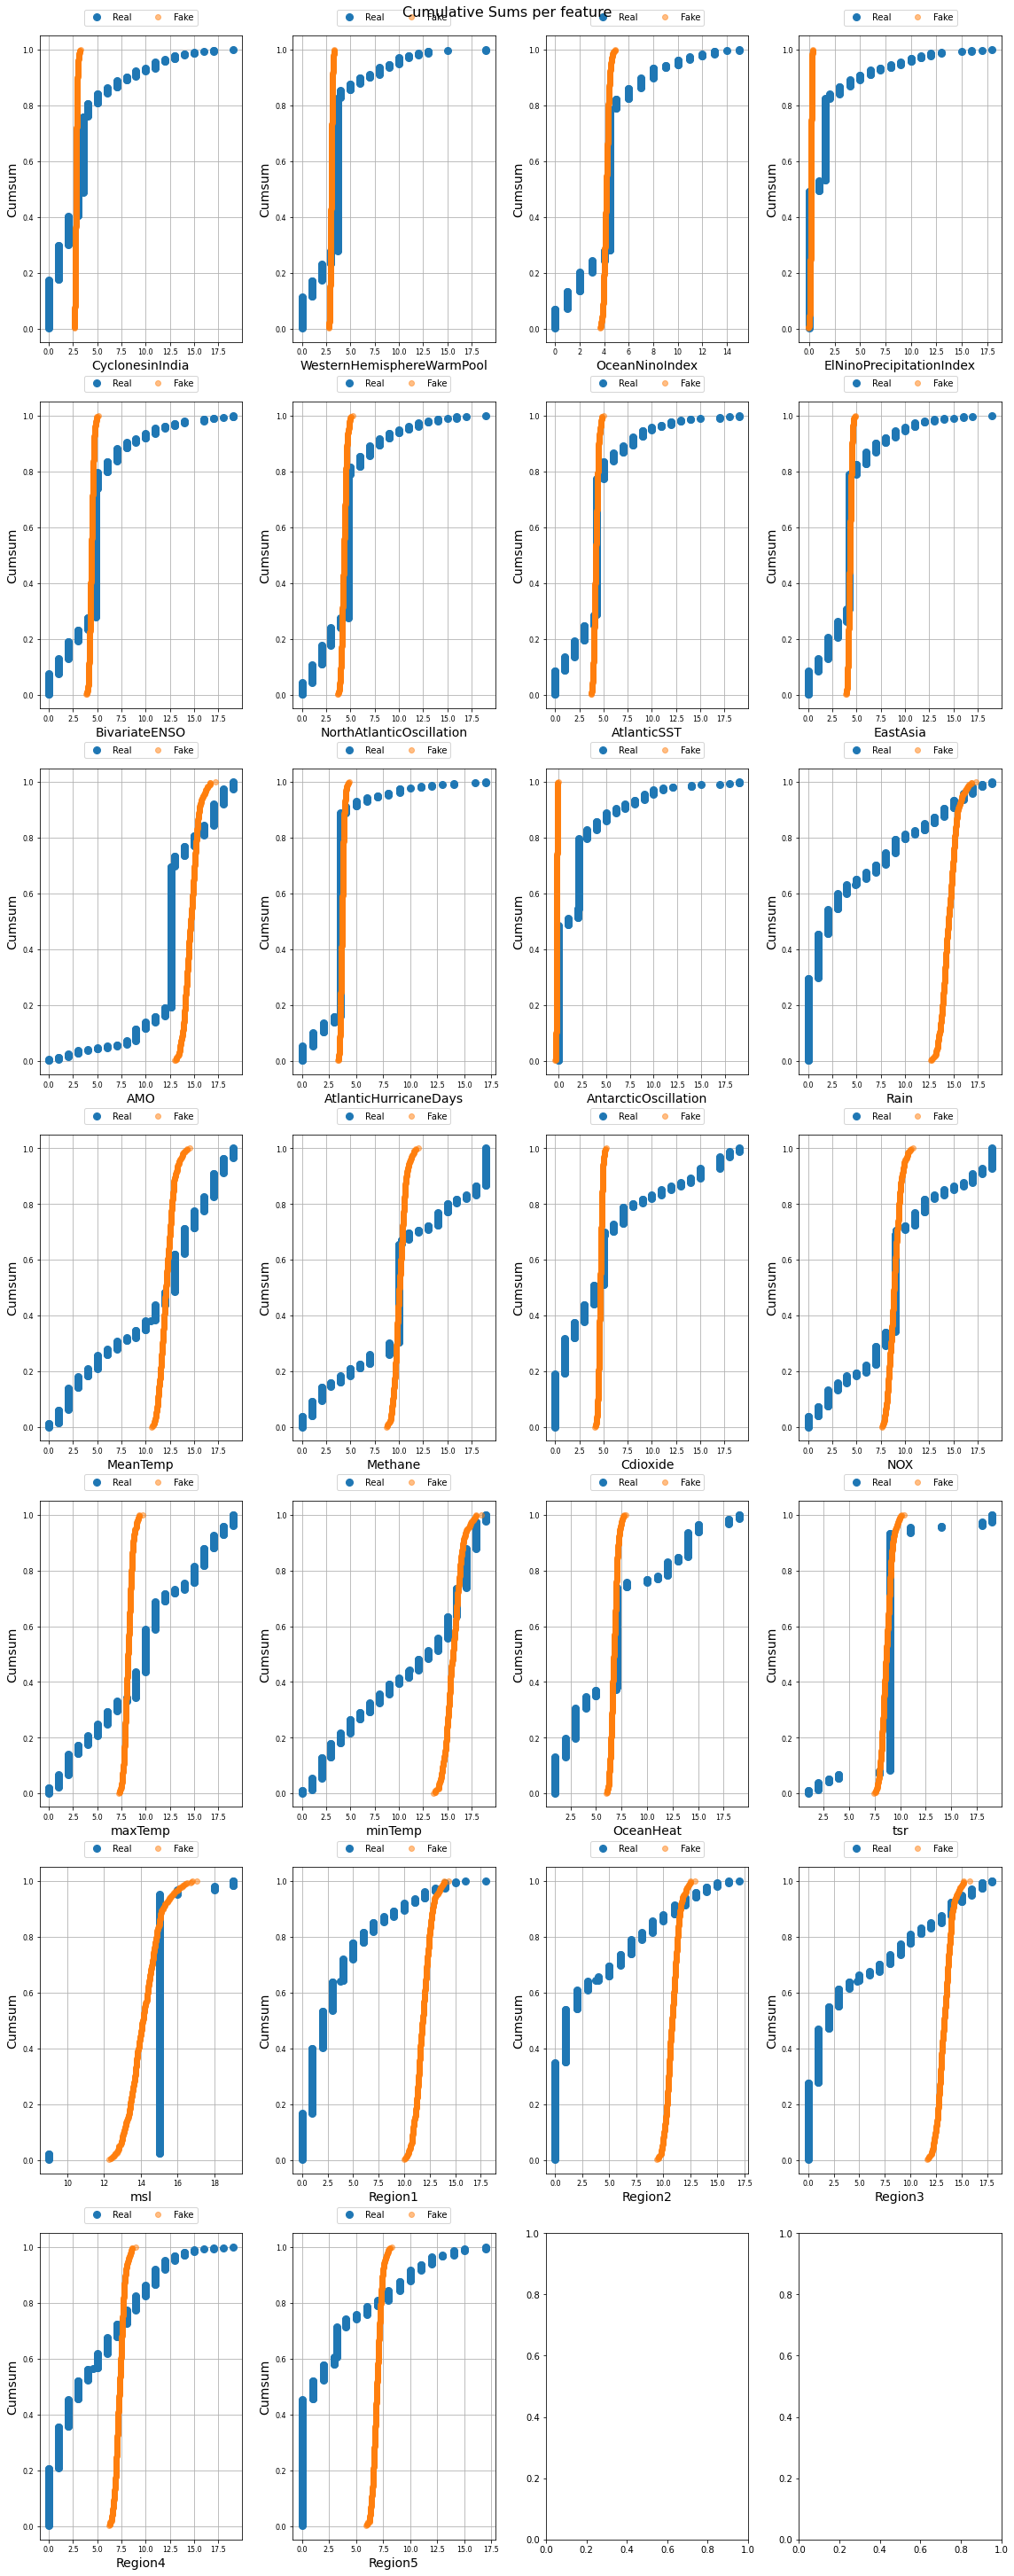

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

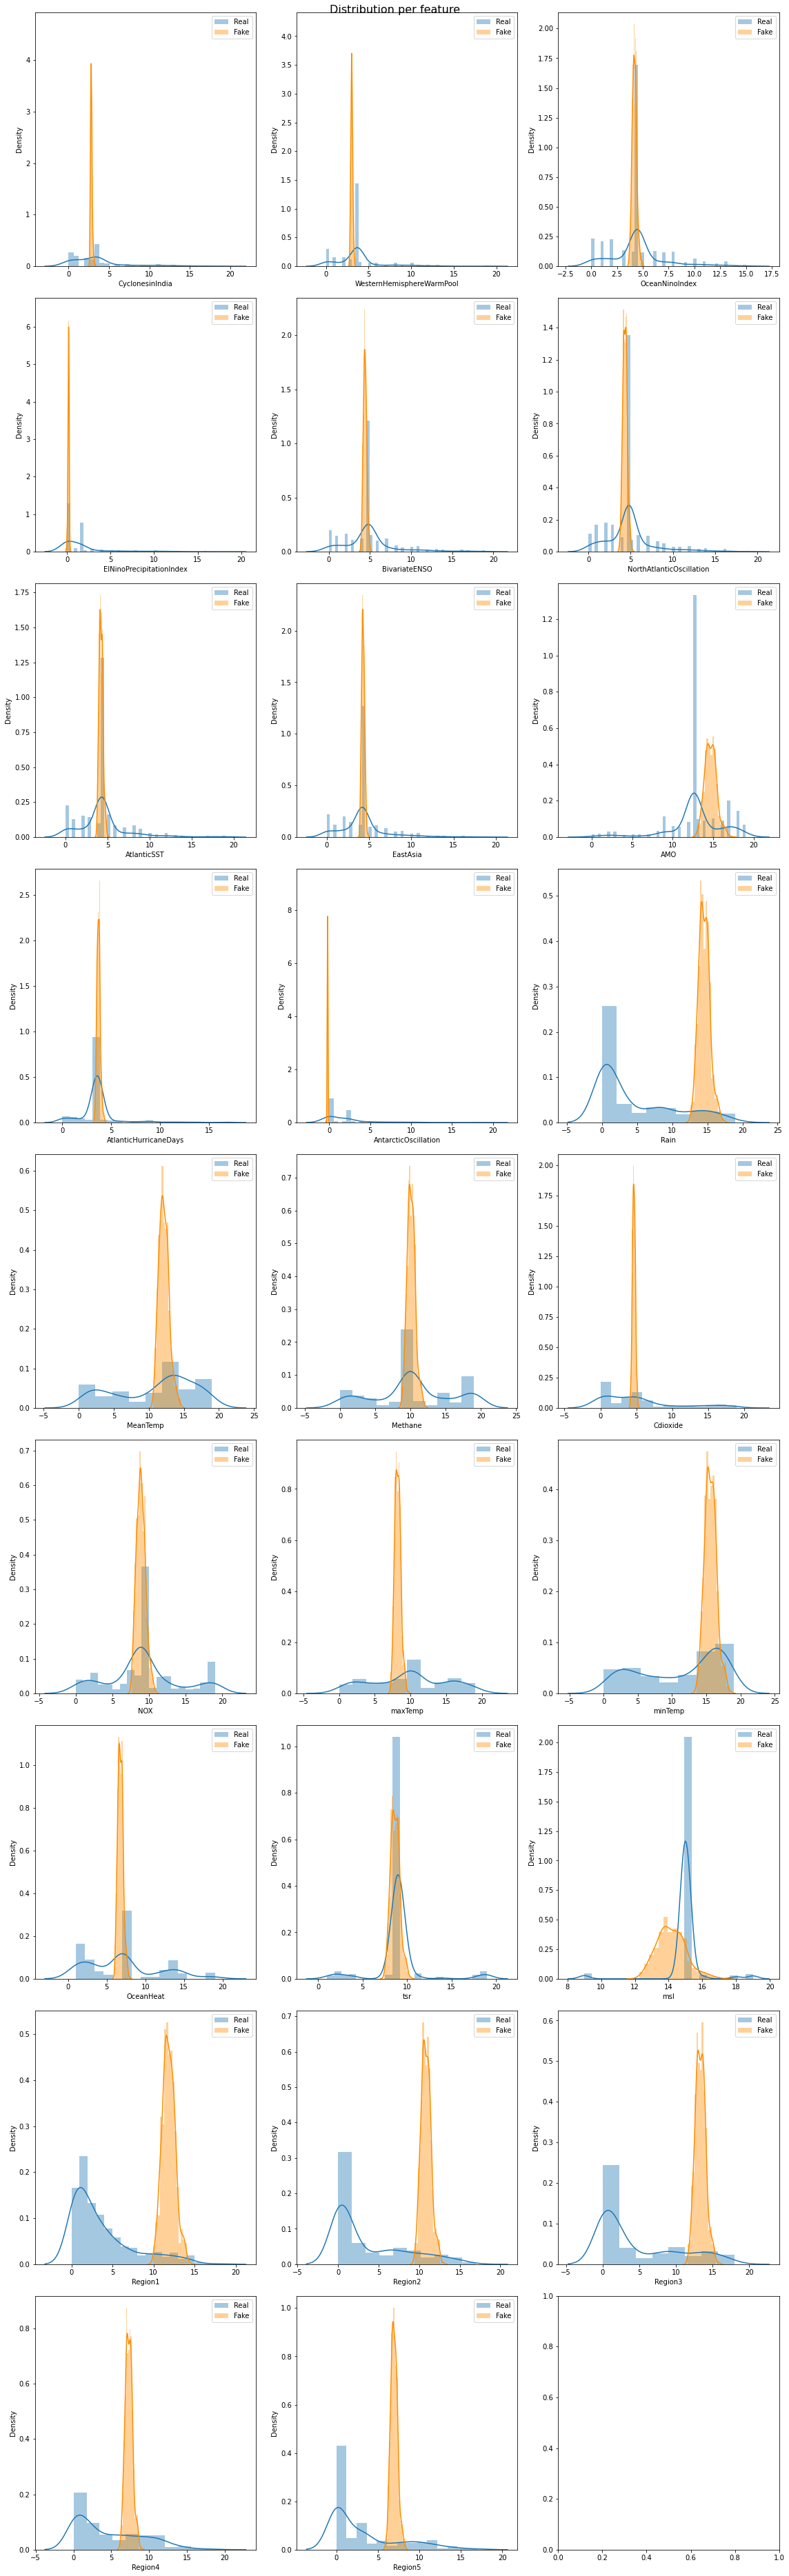

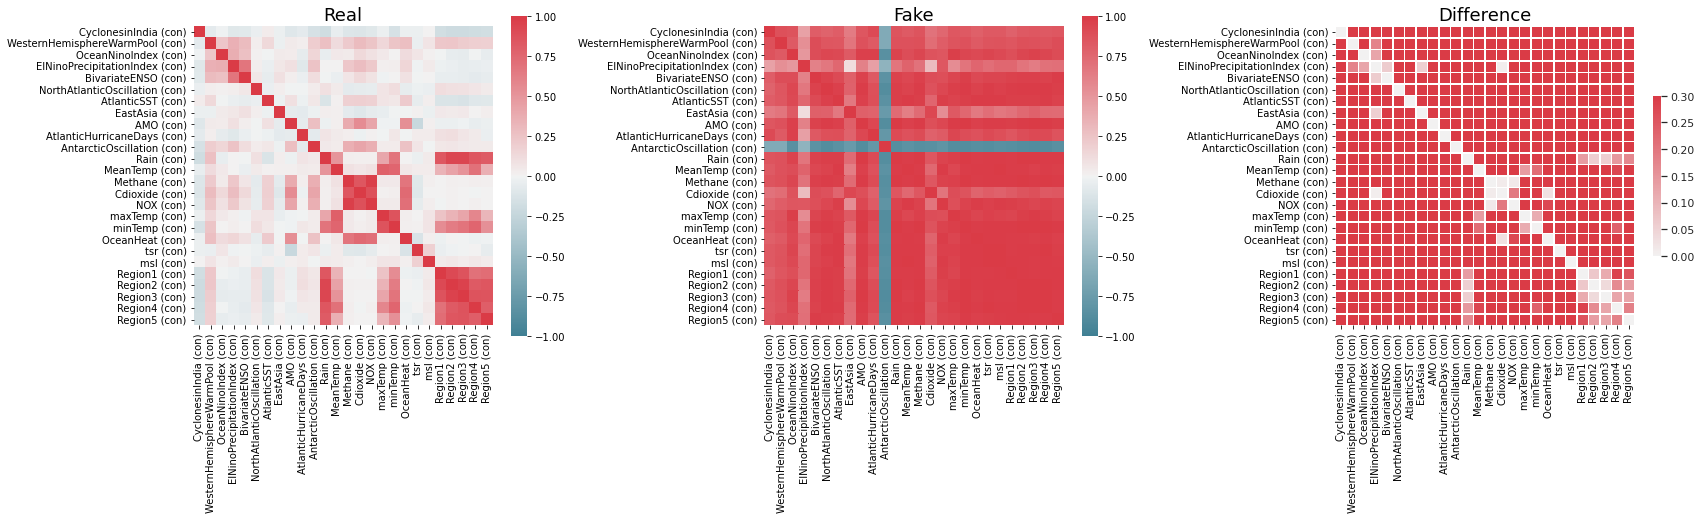

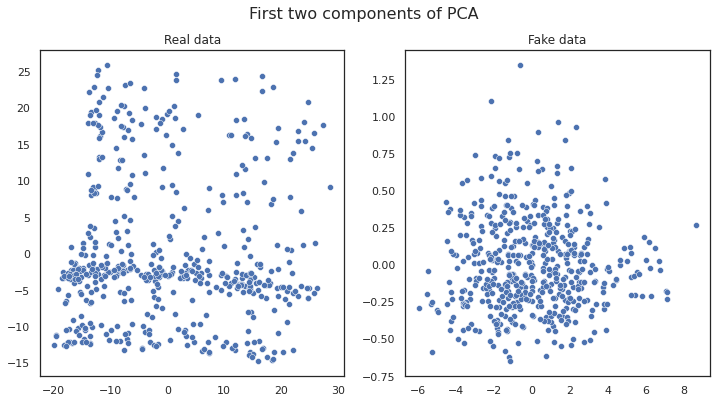

In [ ]:
from table_evaluator import load_data, TableEvaluator
gen_df = gen_samples
df = real_samples
df = df[~df.index.duplicated()]

print(gen_df.columns)
print(df.shape, gen_df.shape)
print(df.columns)

df = df.reset_index(drop=True)

table_evaluator =  TableEvaluator(df, gen_df,)

table_evaluator.visual_evaluation()

X shape: (1340, 20)
Y shape: (1340, 1)
(1270, 70, 20)
(1270, 1)
train_X Shape: (1016, 70, 20) ,test_X Shape: (254, 70, 20)
test_Y Shape: (1016, 1) ,test_Y Shape: (254, 1)


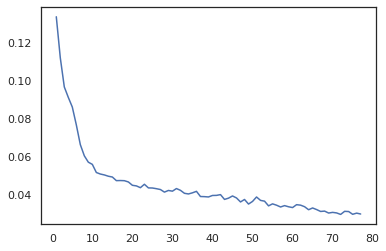

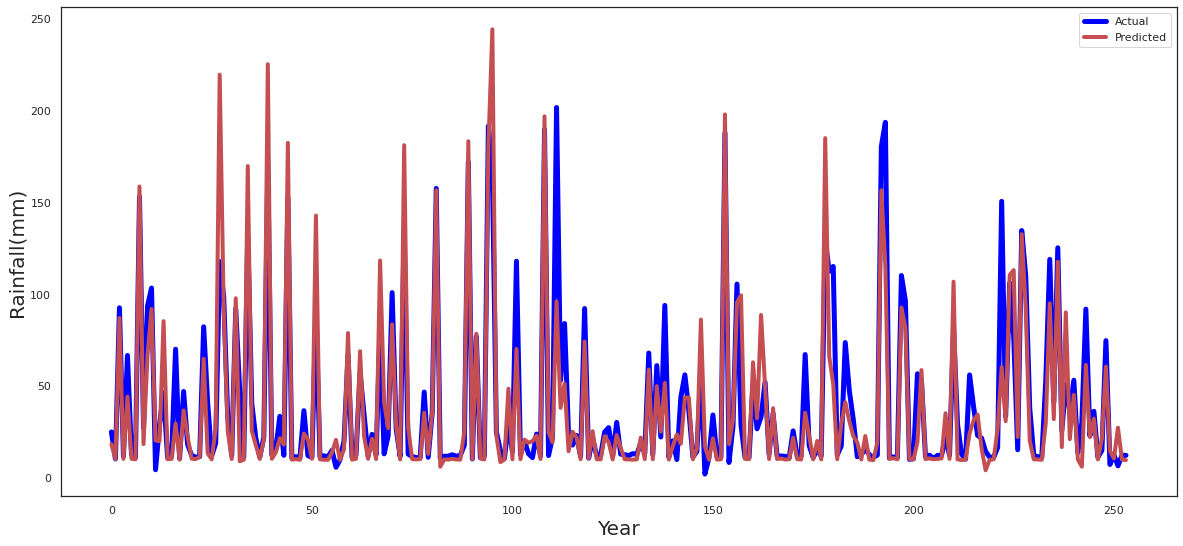

[18.46336, 10.366609, 87.28033, 10.479222, 44.420444, 10.568313, 10.261002, 158.8249, 18.504267, 67.02873, 92.12426, 20.527655, 20.19509, 85.48405, 10.318526, 10.458041, 29.73664, 10.025159, 36.857044, 22.709589, 10.595736, 10.353481, 11.566674, 65.02368, 13.470631, 10.216992, 27.16914, 219.72302, 92.54389, 25.589909, 10.411158, 97.947876, 9.196487, 9.975629, 169.98866, 25.801584, 17.958336, 10.443264, 21.095633, 225.42812, 10.502354, 14.050492, 21.777622, 18.228045, 182.6039, 10.092392, 10.364136, 9.9652195, 24.240288, 20.97404, 10.509835, 142.99718, 10.237767, 10.001477, 9.955864, 13.957662, 20.857288, 9.934514, 15.6675415, 79.03568, 10.047669, 10.539418, 69.11921, 22.903152, 10.531333, 21.39541, 10.385221, 118.527245, 41.304108, 27.21197, 83.729126, 28.490267, 10.168578, 181.31923, 27.364168, 10.349541, 10.231848, 10.321773, 35.65977, 13.199642, 36.162415, 156.78127, 6.198803, 10.180884, 10.115502, 10.486671, 10.14956, 10.08811, 25.179907, 183.45349, 10.307514, 78.614555, 10.684154,

IndexError: ignored

In [ ]:
# All
# CyclonesinIndia	WesternHemisphereWarmPool	NorthAtlanticOscillation	AtlanticHurricaneDays	MeanTemp	maxTemp	minTemp

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf



from re import X

# Regression
# CyclonesinIndia	NorthAtlanticOscillation	
ndls_monthly = pd.read_csv("Generated_sampleLSTM2.csv",usecols=['CyclonesinIndia', 'WesternHemisphereWarmPool',
       'OceanNinoIndex', 'ElNinoPrecipitationIndex', 'BivariateENSO',
       'NorthAtlanticOscillation', 'AtlanticSST', 'EastAsia', 'AMO',
       'AtlanticHurricaneDays', 'AntarcticOscillation', 'Rain', 'MeanTemp',
       'Methane', 'Cdioxide', 'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr',
       'msl', 'Region1', 'Region2', 'Region3', 'Region4', 'Region5'])
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)

X_part=ndls_monthly.drop(["Region1"], axis=1)
X_part=X_part.drop(["Region2"], axis=1)
X_part=X_part.drop(["Region3"], axis=1)
X_part=X_part.drop(["Region4"], axis=1)
X_part=X_part.drop(["Region5"], axis=1)
X_part=X_part.drop(["Rain"], axis=1)
Y_part=ndls_monthly["Region1"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)


scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)

step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)


from sklearn.model_selection import train_test_split
trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.2, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,20)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs1=model2.predict(testR_X)
temp_rs1=scaler2.inverse_transform(temp_rs1)


testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(testR_Y_inv , 'blue', linewidth=5)
plt.plot(temp_rs1,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

# mse=mean_squared_error(testR_Y_inv, temp_rs)
# mae=mean_absolute_error(testR_Y_inv, temp_rs)
# print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))



tempar = []
for i in range(0,temp_rs1.size):
  if temp_rs1[i][0] is np.nan:
    temp_rs1[i][0] = 0
  tempar.append(temp_rs1[i][0])
print(tempar)

tempar2 = []
for i in range(0,temp_rs1.size):
  if testR_Y_inv[i][0] is np.nan:
    testR_Y_inv[i][0] = 0
  tempar2.append(testR_Y_inv[i][0])
print(tempar2)


categorytemp = pd.cut(tempar,bins=[0,100, 200, 300,350, 400, 450, 500, 200000],labels=['0','1','2','3','4','5','6','7'])

print(type(categorytemp))
categorytest = pd.cut(tempar2,bins=[0,100, 200, 300,350, 400, 450, 500, 200000],labels=['0','1','2','3','4','5','6','7'])
print(categorytest)

sum=0
for i in range(0,temp_rs1.size):
  if categorytemp[i] is np.nan:
    categorytemp[i] = '0'
  if categorytest[i] is np.nan:
    categorytest[i] = '0'  
  sum+=abs(int(categorytest[i])-int(categorytemp[i]))

mse=mean_squared_error(categorytest, categorytemp)
mae=mean_absolute_error(categorytest, categorytemp)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))



  




No handles with labels found to put in legend.


[[221  10   1]
 [  4  15   0]
 [  0   3   0]]
label precision recall F1
    0    0.982  0.953
    1    0.536  0.789
    2    0.000  0.000
precision total: 0.505978835978836
recall total: 0.580686630369026
[0.9671772428884026, 0.6382978723404255, 0]
0.9671772428884026
0.6382978723404255
0
F1 score is  1.605475115228828
Accuracy is  0.9291338582677166
[0.23684210526315788, 0.23684210526315788, 0.23684210526315788]
Specificity is  0.7631578947368421
MCC is  0.23684210526315788
[0.3793103448275862, 0.3191489361702128, 0.23684210526315785]
[0.9822222222222222, 0.46875, 0.0]


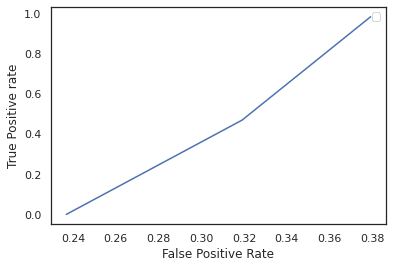

In [ ]:


from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,which compares the y_test and y_pred
import numpy as np
cm = confusion_matrix(categorytemp , categorytest)
print(cm)
fpr = []
tpr = []


# Calculating parameters
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns


print("label precision recall F1")
f1 = []
for label in range(0,3):
    if precision(label,cm)==0 or recall(label,cm)==0:
      f1.append(0)
    else:
      f1.append(2*precision(label,cm)*recall(label,cm)/(precision(label,cm)+recall(label,cm)))
    print(f"{label:5d} {precision(label, cm):8.3f} {recall(label, cm):6.3f}")
    

print("precision total:", precision_macro_average(cm))

print("recall total:", recall_macro_average(cm))
print(f1)
f1sum = 0
import math
for i in range(0,len(f1)):
  if f1[i] is math.nan:
    f1[i] = 0
    print("XYZ")
  print(f1[i])
  f1sum = f1sum +  f1[i]

print("F1 score is ", f1sum)

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

print("Accuracy is ",accuracy(cm))

import math

def valueForLabel(confusion_matrix):
  rows, columns = confusion_matrix.shape
  
  #  tpr[i] = TP[i]/(TP[i]+FN[i])
  FP = 0 
  TN = 0
  FN = 0
  for label in range(rows):
    TP = cm[label,label]
    
    for i in range(0,3):
      if i!=label:
        FP = FP + cm[label][i]
        FN = FN + cm[i][label] 
        for j in range(1,3):
          TN = TN + cm[i][j] 
    tpr.append(TP/(TP+FN))
    fpr.append(1 - (TN/(TN+FP)))

    specificity = []
    MCC = []
    for i in range(0,3):
      if ((TP*TN) - (FP*FN)) is None:
        MCC.append(0)
      else:
        MCC.append(abs(((TP*TN) - (FP*FN)) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))))
      specificity.append(TN/(TN+FP))
      
  
  spec_avg = np.sum(specificity)/len(specificity)
  print(MCC)
  mcc_avg = np.sum(MCC)/len(MCC)
  print("Specificity is ",spec_avg)
  print("MCC is ",mcc_avg)

  
valueForLabel(cm)
#TP = cm[0][0] #206
#FP = cm[1][0]+cm[2][0] # 0
#TN = cm[1][1]+cm[2][1] + cm[2][1]+cm[2][2] # 0
#FN = cm[0][1]+cm[0][2] # 46
# sum 252
#precision = TP / (TP+FP) # 1
#accuracy = (TP+TN) / N # 81.74
#recall = TP/(TP+FN) # 0.8174
#fonescore = 2*precision*recall/(precision+recall) # 0.899
# specificity = TN/(TN+FP) # 1
#obs = (TP+TN)/N # 0.8174

#expec = ((6/7 ) + (4/5 )) # 1.657
#kappa = (obs - expec)/(1-expec) #1.278

#MCC = ((TP*TN) - (FP*FN)) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# ROC Curve
from sklearn.metrics import roc_curve
import numpy as np

# True Positive Rate = True Positives / (True Positives + False Negatives)
# False Positive Rate = 1 - Specificity

# roc curve for classes
#fpr = []
#tpr = []
#thresh =[]

#n_class = 7
print(fpr)
print(tpr)

    
# plotting    
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  
#fpr, tpr, thresholds = roc_curve(probas,testR_Y_inv,pos_label=1)
#plt.plot(fpr,color='orange', label = 'fpr')
#plt.plot(tpr,color='green', label = 'tpr')
#plt.legend(fontsize=16)

#AUC
from sklearn import metrics
fprx = []
fprx.append(fpr[0])
fprx.append(fpr[1])
fprx.append(fpr[2])

tprx = []
tprx.append(tpr[0])
tprx.append(tpr[1])
tprx.append(tpr[2])

#plt.plot(fprx, tprx)
#auc = metrics.auc(fprx, tprx)
#print(auc)

In [ ]:
# All
# CyclonesinIndia	WesternHemisphereWarmPool	NorthAtlanticOscillation	AtlanticHurricaneDays	MeanTemp	maxTemp	minTemp

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from tensorflow.keras import models, layers, utils, optimizers, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf



from re import X

# Regression
# CyclonesinIndia	NorthAtlanticOscillation	
ndls_monthly = pd.read_csv("Generated_sampleLSTM2.csv",usecols=['CyclonesinIndia', 'WesternHemisphereWarmPool',
       'OceanNinoIndex', 'ElNinoPrecipitationIndex', 'BivariateENSO',
       'NorthAtlanticOscillation', 'AtlanticSST', 'EastAsia', 'AMO',
       'AtlanticHurricaneDays', 'AntarcticOscillation', 'Rain', 'MeanTemp',
       'Methane', 'Cdioxide', 'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr',
       'msl', 'Region1', 'Region2', 'Region3', 'Region4', 'Region5'])
ndls_monthly.fillna(ndls_monthly.mean(), inplace=True)

X_part=ndls_monthly.drop(["Region1"], axis=1)
X_part=X_part.drop(["Region2"], axis=1)
X_part=X_part.drop(["Region3"], axis=1)
X_part=X_part.drop(["Region4"], axis=1)
X_part=X_part.drop(["Region5"], axis=1)
X_part=X_part.drop(["Rain"], axis=1)
Y_part=ndls_monthly["Region1"]
X_part=np.array(X_part)
Y_part=np.array(Y_part).reshape(-1,1)
print("X shape:",X_part.shape)
print("Y shape:",Y_part.shape)


scaler2=MinMaxScaler(feature_range=(0,1))
X_part_scaled=scaler2.fit_transform(X_part)
Y_part_scaled=scaler2.fit_transform(Y_part)

step=70
input=[]
output=[]
for i in range(len(X_part_scaled)-(step)):
    input.append(X_part_scaled[i:i+step])
    output.append(Y_part_scaled[i+step])
 
input=np.array(input)
output=np.array(output)

print(input.shape)
print(output.shape)


from sklearn.model_selection import train_test_split
trainR_X, testR_X, trainR_Y, testR_Y = train_test_split(input,output, test_size = 0.2, random_state = 1)

print("train_X Shape:",trainR_X.shape, ",test_X Shape:", testR_X.shape)
print("test_Y Shape:",trainR_Y.shape, ",test_Y Shape:", testR_Y.shape)

model2=models.Sequential()
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu", input_shape=(70,20)))

model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.MaxPool1D(pool_size=2))
model2.add(layers.Conv1D(filters=128, kernel_size=2, activation="relu"))
model2.add(layers.Flatten())
model2.add(layers.RepeatVector(70)) #same as input (30,1)=30
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.LSTM(units=100, return_sequences=True, activation="relu"))
model2.add(layers.Dropout(0.2))
model2.add(layers.Bidirectional(layers.LSTM(units=128, activation="relu")))
model2.add(layers.Dense(100, activation="relu"))
model2.add(layers.Dense(1))

model2.compile(optimizer=optimizers.Adam(learning_rate=0.00001), loss="mae", metrics=["mse"])

EarlyStp=callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

Savemod=callbacks.ModelCheckpoint(filepath="model2_R.h5", monitor="loss", save_best_only=True)

history=model2.fit(trainR_X, trainR_Y, epochs=500, verbose=0, callbacks=[Savemod, EarlyStp])

hist=history.history
train_loss=hist["loss"]
epoch=range(1,len(train_loss)+1)  #hist is a dict
plt.plot(epoch, train_loss)
model2=models.load_model("model2_R.h5")
temp_rs1=model2.predict(testR_X)
temp_rs1=scaler2.inverse_transform(temp_rs1)


testR_Y_inv=scaler2.inverse_transform(testR_Y)
plt.figure(figsize=(20,9))
plt.plot(testR_Y_inv , 'blue', linewidth=5)
plt.plot(temp_rs1,'r' , linewidth=4)
plt.xlabel("Year", fontsize=20)
plt.ylabel("Rainfall(mm)", fontsize=20)
plt.legend(('Actual','Predicted'))
plt.show()

# mse=mean_squared_error(testR_Y_inv, temp_rs)
# mae=mean_absolute_error(testR_Y_inv, temp_rs)
# print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))



tempar = []
for i in range(0,temp_rs1.size):
  if temp_rs1[i][0] is np.nan:
    temp_rs1[i][0] = 0
  tempar.append(temp_rs1[i][0])
print(tempar)

tempar2 = []
for i in range(0,temp_rs1.size):
  if testR_Y_inv[i][0] is np.nan:
    testR_Y_inv[i][0] = 0
  tempar2.append(testR_Y_inv[i][0])
print(tempar2)


categorytemp = pd.cut(tempar,bins=[0,50, 100, 150,200, 250, 300, 350, 200000],labels=['0','1','2','3','4','5','6','7'])

print(type(categorytemp))
categorytest = pd.cut(tempar2,bins=[0,50, 100, 150,200, 250, 300, 350, 200000],labels=['0','1','2','3','4','5','6','7'])
print(categorytest)

sum=0
for i in range(0,temp_rs1.size):
  if categorytemp[i] is np.nan:
    categorytemp[i] = '0'
  if categorytest[i] is np.nan:
    categorytest[i] = '0'  
  sum+=abs(int(categorytest[i])-int(categorytemp[i]))

mse=mean_squared_error(categorytest, categorytemp)
mae=mean_absolute_error(categorytest, categorytemp)
print("Mean Squared Error:", str(mse), "and Mean Absolute Error:", str(mae))


from sklearn.metrics import confusion_matrix
# Creating  a confusion matrix,which compares the y_test and y_pred
import numpy as np
cm = confusion_matrix(categorytemp , categorytest)
print(cm)
fpr = []
tpr = []


# Calculating parameters
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    return confusion_matrix[label, label] / col.sum()
    
def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns


print("label precision recall F1")
f1 = []
for label in range(0,7):
    if precision(label,cm)==0 or recall(label,cm)==0:
      f1.append(0)
    else:
      f1.append(2*precision(label,cm)*recall(label,cm)/(precision(label,cm)+recall(label,cm)))
    print(f"{label:5d} {precision(label, cm):8.3f} {recall(label, cm):6.3f}")
    

print("precision total:", precision_macro_average(cm))

print("recall total:", recall_macro_average(cm))
print(f1)
f1sum = 0
for i in range(0,len(f1)):
  if f1[i] is math.nan:
    f1[i] = 0
    print("XYZ")
  print(f1[i])
  f1sum = f1sum +  f1[i]

print("F1 score is ", f1sum)

def accuracy(confusion_matrix):
    diagonal_sum = confusion_matrix.trace()
    sum_of_all_elements = confusion_matrix.sum()
    return diagonal_sum / sum_of_all_elements 

print("Accuracy is ",accuracy(cm))

import math

def valueForLabel(confusion_matrix):
  rows, columns = confusion_matrix.shape
  
  #  tpr[i] = TP[i]/(TP[i]+FN[i])
  FP = 0 
  TN = 0
  FN = 0
  for label in range(rows):
    TP = cm[label,label]
    
    for i in range(0,7):
      if i!=label:
        FP = FP + cm[label][i]
        FN = FN + cm[i][label] 
        for j in range(1,7):
          TN = TN + cm[i][j] 
    tpr.append(TP/(TP+FN))
    fpr.append(1 - (TN/(TN+FP)))

    specificity = []
    MCC = []
    for i in range(0,7):
      if ((TP*TN) - (FP*FN)) is None:
        MCC.append(0)
      else:
        MCC.append(abs(((TP*TN) - (FP*FN)) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))))
      specificity.append(TN/(TN+FP))
      
  
  spec_avg = np.sum(specificity)/len(specificity)
  print(MCC)
  mcc_avg = np.sum(MCC)/len(MCC)
  print("Specificity is ",spec_avg)
  print("MCC is ",mcc_avg)
  

valueForLabel(cm)
#TP = cm[0][0] #206
#FP = cm[1][0]+cm[2][0] # 0
#TN = cm[1][1]+cm[2][1] + cm[2][1]+cm[2][2] # 0
#FN = cm[0][1]+cm[0][2] # 46
# sum 252
#precision = TP / (TP+FP) # 1
#accuracy = (TP+TN) / N # 81.74
#recall = TP/(TP+FN) # 0.8174
#fonescore = 2*precision*recall/(precision+recall) # 0.899
# specificity = TN/(TN+FP) # 1
#obs = (TP+TN)/N # 0.8174

#expec = ((6/7 ) + (4/5 )) # 1.657
#kappa = (obs - expec)/(1-expec) #1.278

#MCC = ((TP*TN) - (FP*FN)) / math.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# ROC Curve
from sklearn.metrics import roc_curve
import numpy as np

# True Positive Rate = True Positives / (True Positives + False Negatives)
# False Positive Rate = 1 - Specificity

# roc curve for classes
#fpr = []
#tpr = []
#thresh =[]

#n_class = 7
print(fpr)
print(tpr)

    
# plotting    
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);  
#fpr, tpr, thresholds = roc_curve(probas,testR_Y_inv,pos_label=1)
#plt.plot(fpr,color='orange', label = 'fpr')
#plt.plot(tpr,color='green', label = 'tpr')
#plt.legend(fontsize=16)

#AUC
from sklearn import metrics
fprx = []
fprx.append(fpr[0])
fprx.append(fpr[1])
fprx.append(fpr[2])
fprx.append(fpr[3])
fprx.append(fpr[6])

tprx = []
tprx.append(tpr[0])
tprx.append(tpr[1])
tprx.append(tpr[2])
tprx.append(tpr[3])
tprx.append(tpr[6])

#plt.plot(fprx, tprx)
#auc = metrics.auc(fprx, tprx)
#print(auc)



No handles with labels found to put in legend.


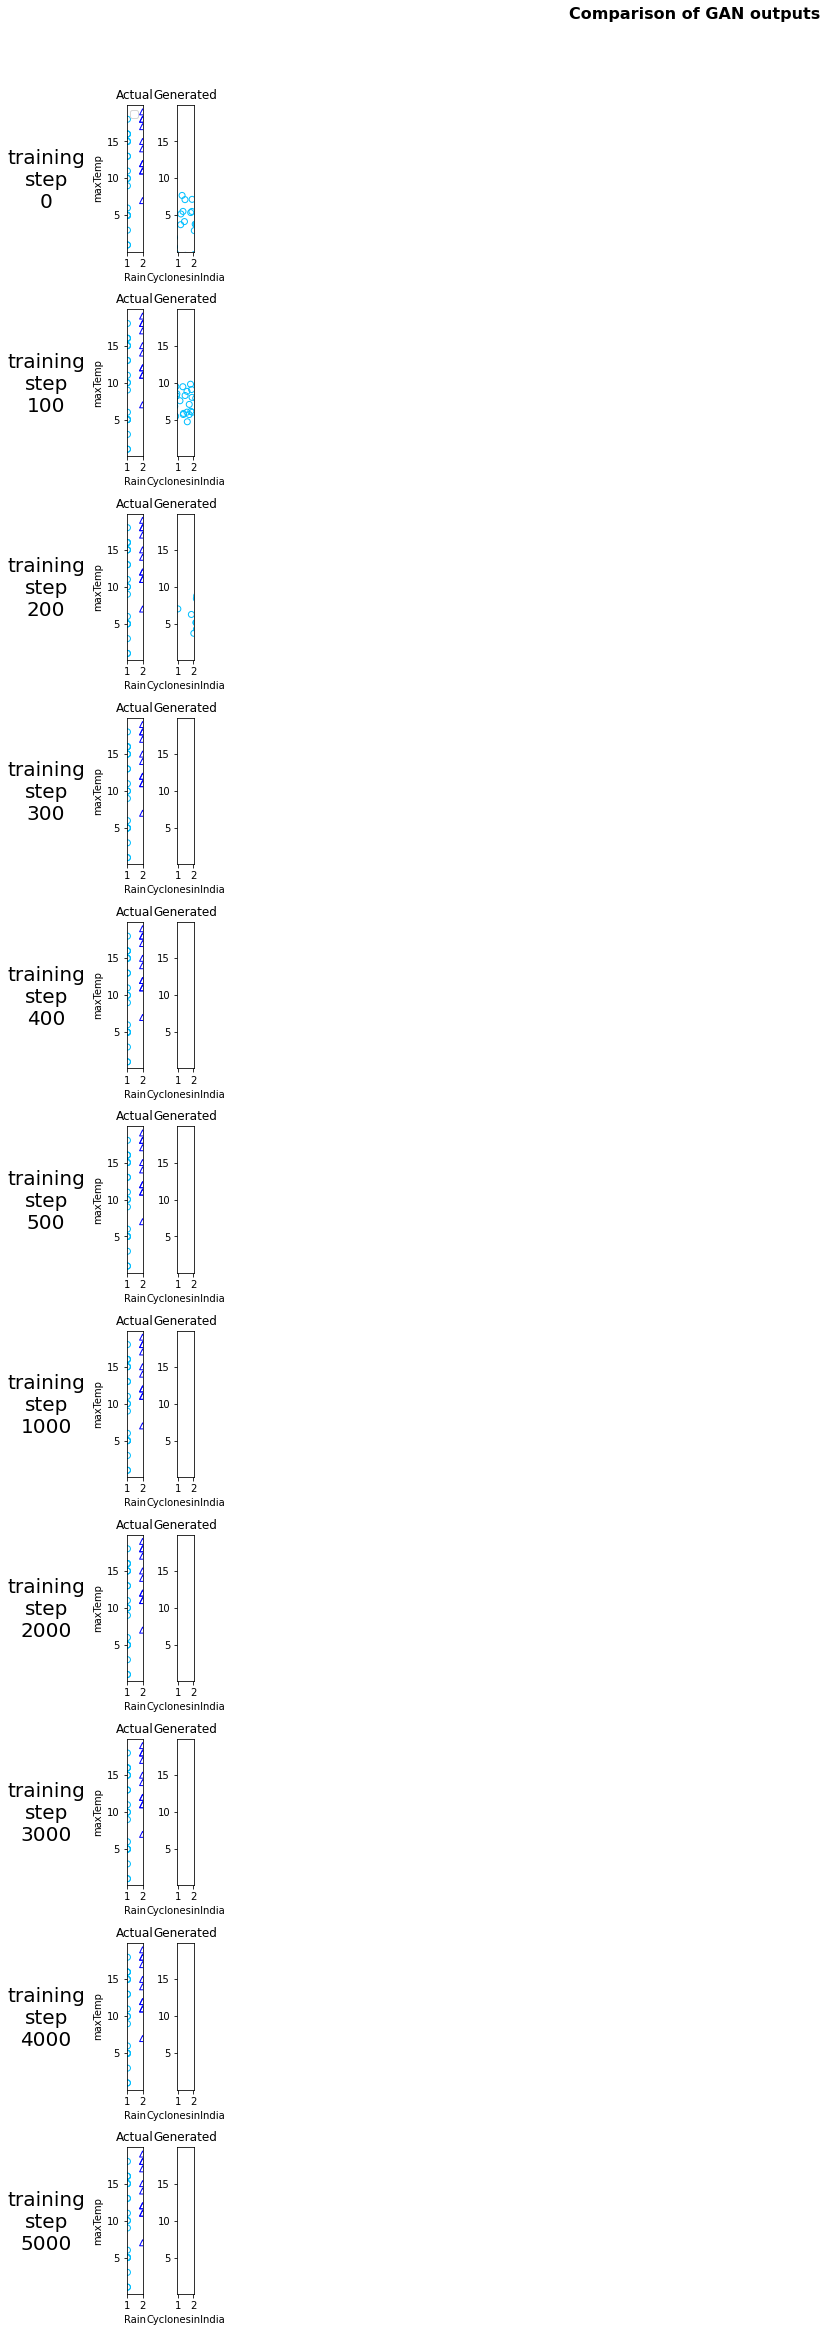

In [ ]:
import matplotlib.pyplot as plt

# Setup parameters visualization parameters
seed = 17
test_size = 128 
noise_dim = 32

np.random.seed(seed)
z = np.random.normal(size=(test_size, noise_dim))
real = synthesizer.get_data_batch(train=df, batch_size=test_size, seed=seed)
real_samples = pd.DataFrame(real, columns=data_cols)

model_names = ['GAN']
colors = ['deepskyblue','blue']
markers = ['o','^']

col1, col2 = 'Rain', 'maxTemp'

base_dir = 'model/'

#Actual data visualization
model_steps = [ 0, 100, 200, 300, 400, 500, 1000, 2000, 3000, 4000, 5000]
rows = len(model_steps)
columns = 26

axarr = [[]]*len(model_steps)

fig = plt.figure(figsize=(20,rows*3))

for model_step_ix, model_step in enumerate(model_steps):        
    axarr[model_step_ix] = plt.subplot(rows, columns, model_step_ix*columns + 1)
    
    for group, color, marker in zip(real_samples.groupby('Rain'), colors, markers):
        plt.scatter( group[1][[col1]], group[1][[col2]], marker=marker, edgecolors=color, facecolors='none' )
    
    plt.title('Actual')
    plt.ylabel(col2) # Only add y label to left plot
    plt.xlabel(col1)
    xlims, ylims = axarr[model_step_ix].get_xlim(), axarr[model_step_ix].get_ylim()
    
    if model_step_ix == 0: 
        legend = plt.legend()
        legend.get_frame().set_facecolor('white')
    
    i=0
    [model_name, with_class, generator_model] = models['GAN']

    generator_model.load_weights( base_dir + '_generator_model_weights_step_'+str(model_step)+'.h5')

    ax = plt.subplot(rows, columns, model_step_ix*columns + 1 + (i+1) )

    g_z = generator_model.predict(z)
    gen_samples = pd.DataFrame(g_z, columns=data_cols)
    # gen_samples.to_csv('Generated_sample.csv')
    plt.scatter( gen_samples[[col1]], gen_samples[[col2]], marker=markers[0], edgecolors=colors[0], facecolors='none' )
    plt.title("Generated")   
    plt.xlabel(data_cols[0])
    ax.set_xlim(xlims), ax.set_ylim(ylims)

plt.suptitle('Comparison of GAN outputs', size=16, fontweight='bold')
plt.tight_layout(rect=[0.075,0,1,0.95])

# Adding text labels for traning steps
vpositions = np.array([ i._position.bounds[1] for i in axarr ])
vpositions += ((vpositions[0] - vpositions[1]) * 0.35 )
for model_step_ix, model_step in enumerate( model_steps ):
    fig.text( 0.05, vpositions[model_step_ix], 'training\nstep\n'+str(model_step), ha='center', va='center', size=20)

plt.savefig('Comparison_of_GAN_outputs.png')

In [ ]:
!pip install table_evaluator


Index(['CyclonesinIndia', 'WesternHemisphereWarmPool', 'OceanNinoIndex',
       'ElNinoPrecipitationIndex', 'BivariateENSO', 'NorthAtlanticOscillation',
       'AtlanticSST', 'EastAsia', 'AMO', 'AtlanticHurricaneDays',
       'AntarcticOscillation', 'Rain', 'MeanTemp', 'Methane', 'Cdioxide',
       'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr', 'msl', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region5'],
      dtype='object')
(128, 26) (128, 26)
Index(['CyclonesinIndia', 'WesternHemisphereWarmPool', 'OceanNinoIndex',
       'ElNinoPrecipitationIndex', 'BivariateENSO', 'NorthAtlanticOscillation',
       'AtlanticSST', 'EastAsia', 'AMO', 'AtlanticHurricaneDays',
       'AntarcticOscillation', 'Rain', 'MeanTemp', 'Methane', 'Cdioxide',
       'NOX', 'maxTemp', 'minTemp', 'OceanHeat', 'tsr', 'msl', 'Region1',
       'Region2', 'Region3', 'Region4', 'Region5'],
      dtype='object')


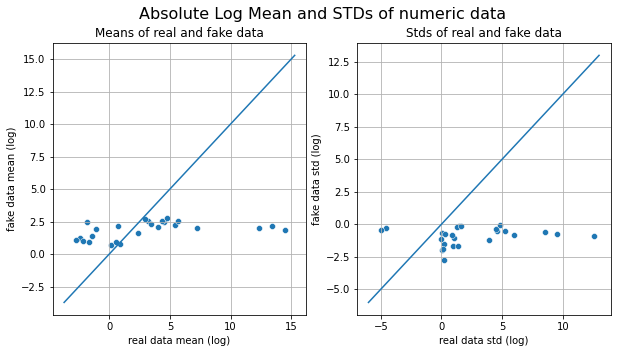

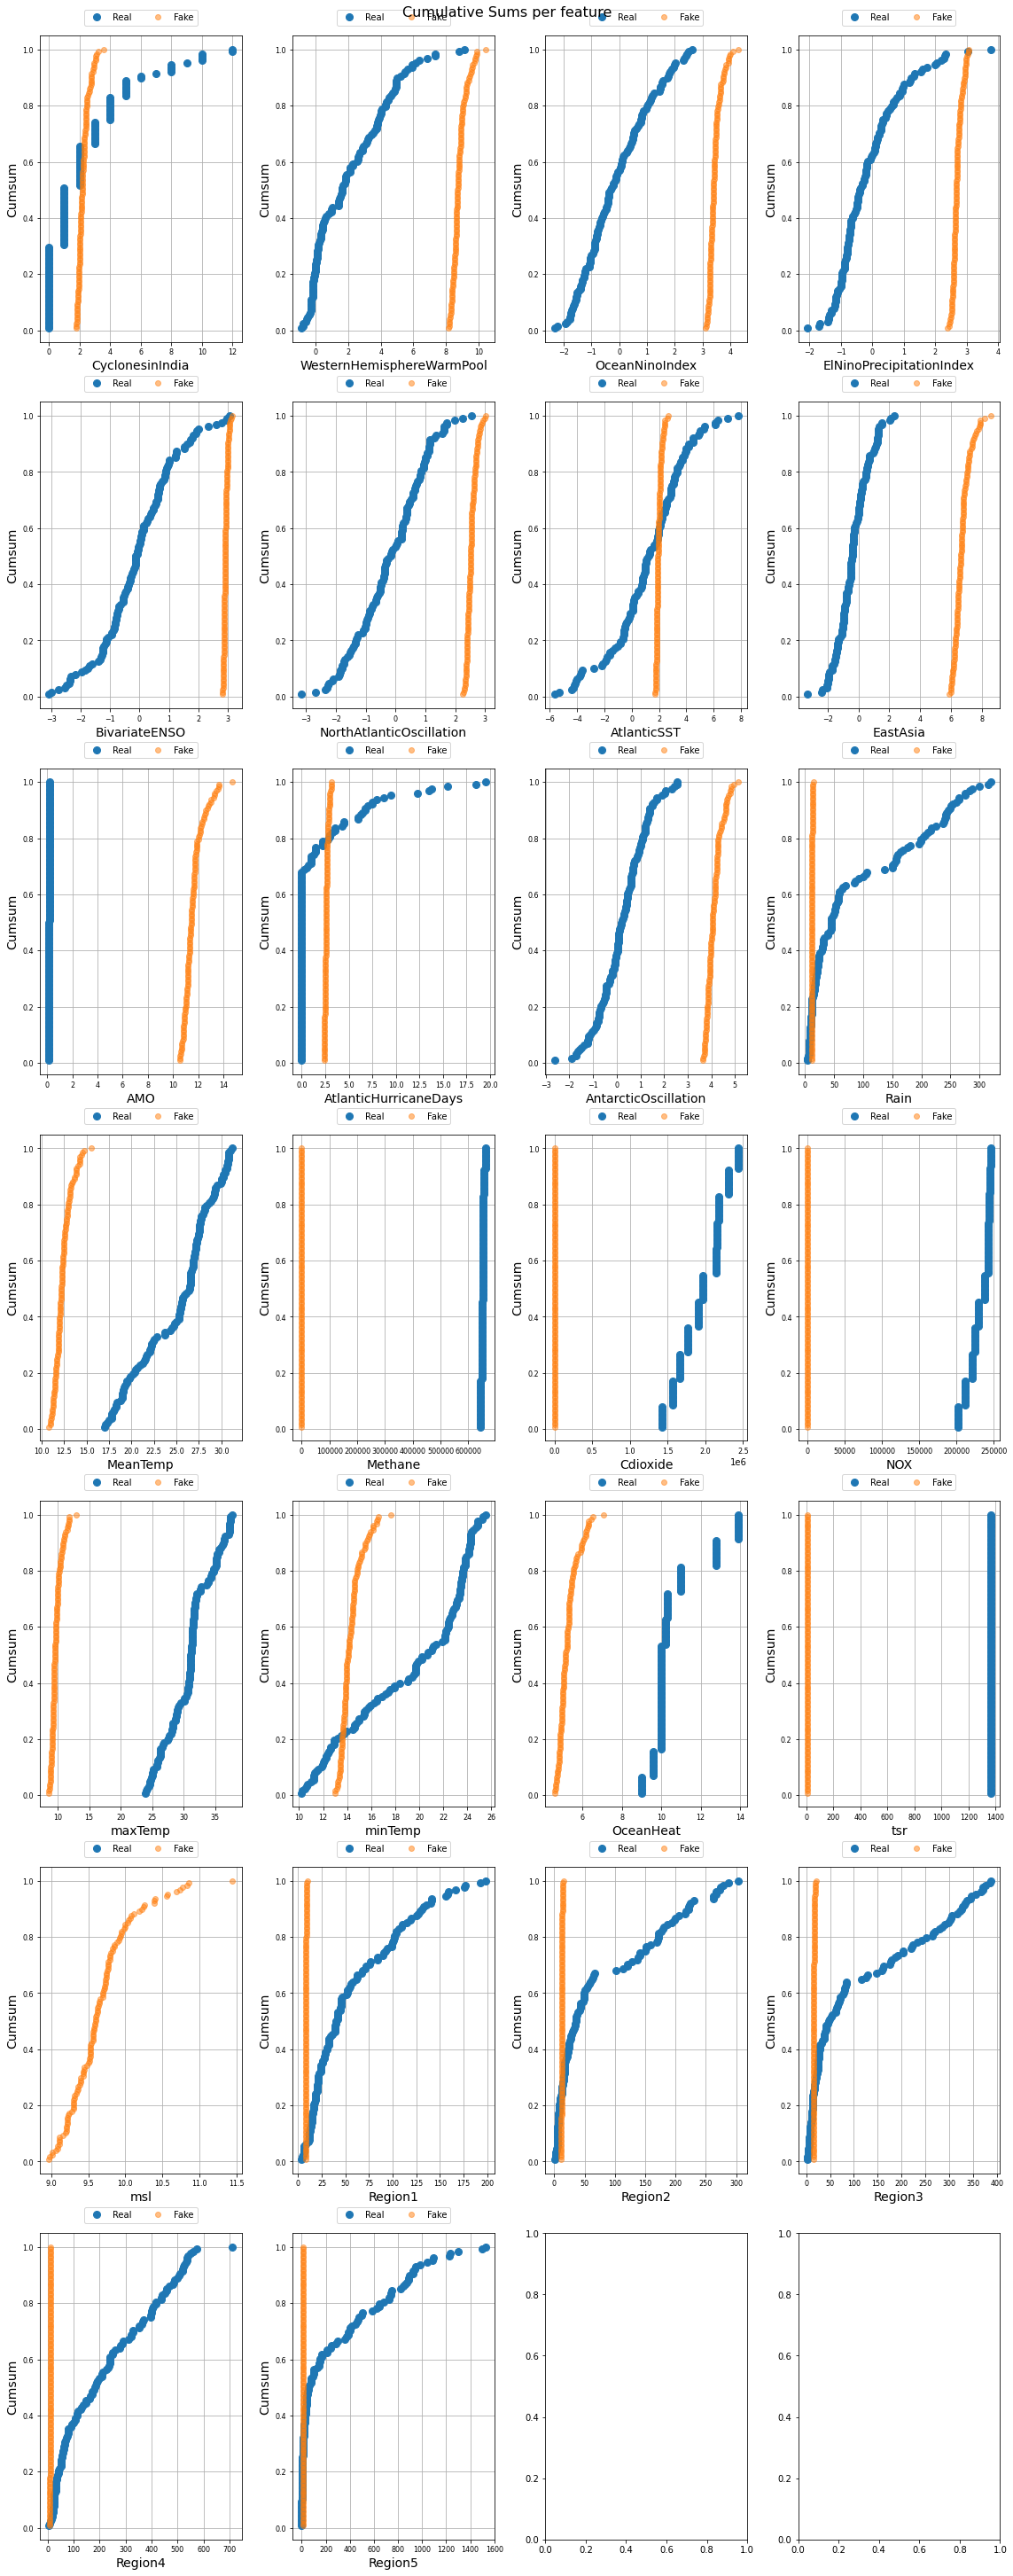

/usr/local/lib/python3.7/dist-packages/seaborn/_statistics.py:369: RuntimeWarning: invalid value encountered in true_divide
  hist = hist.astype(float) / hist.sum()


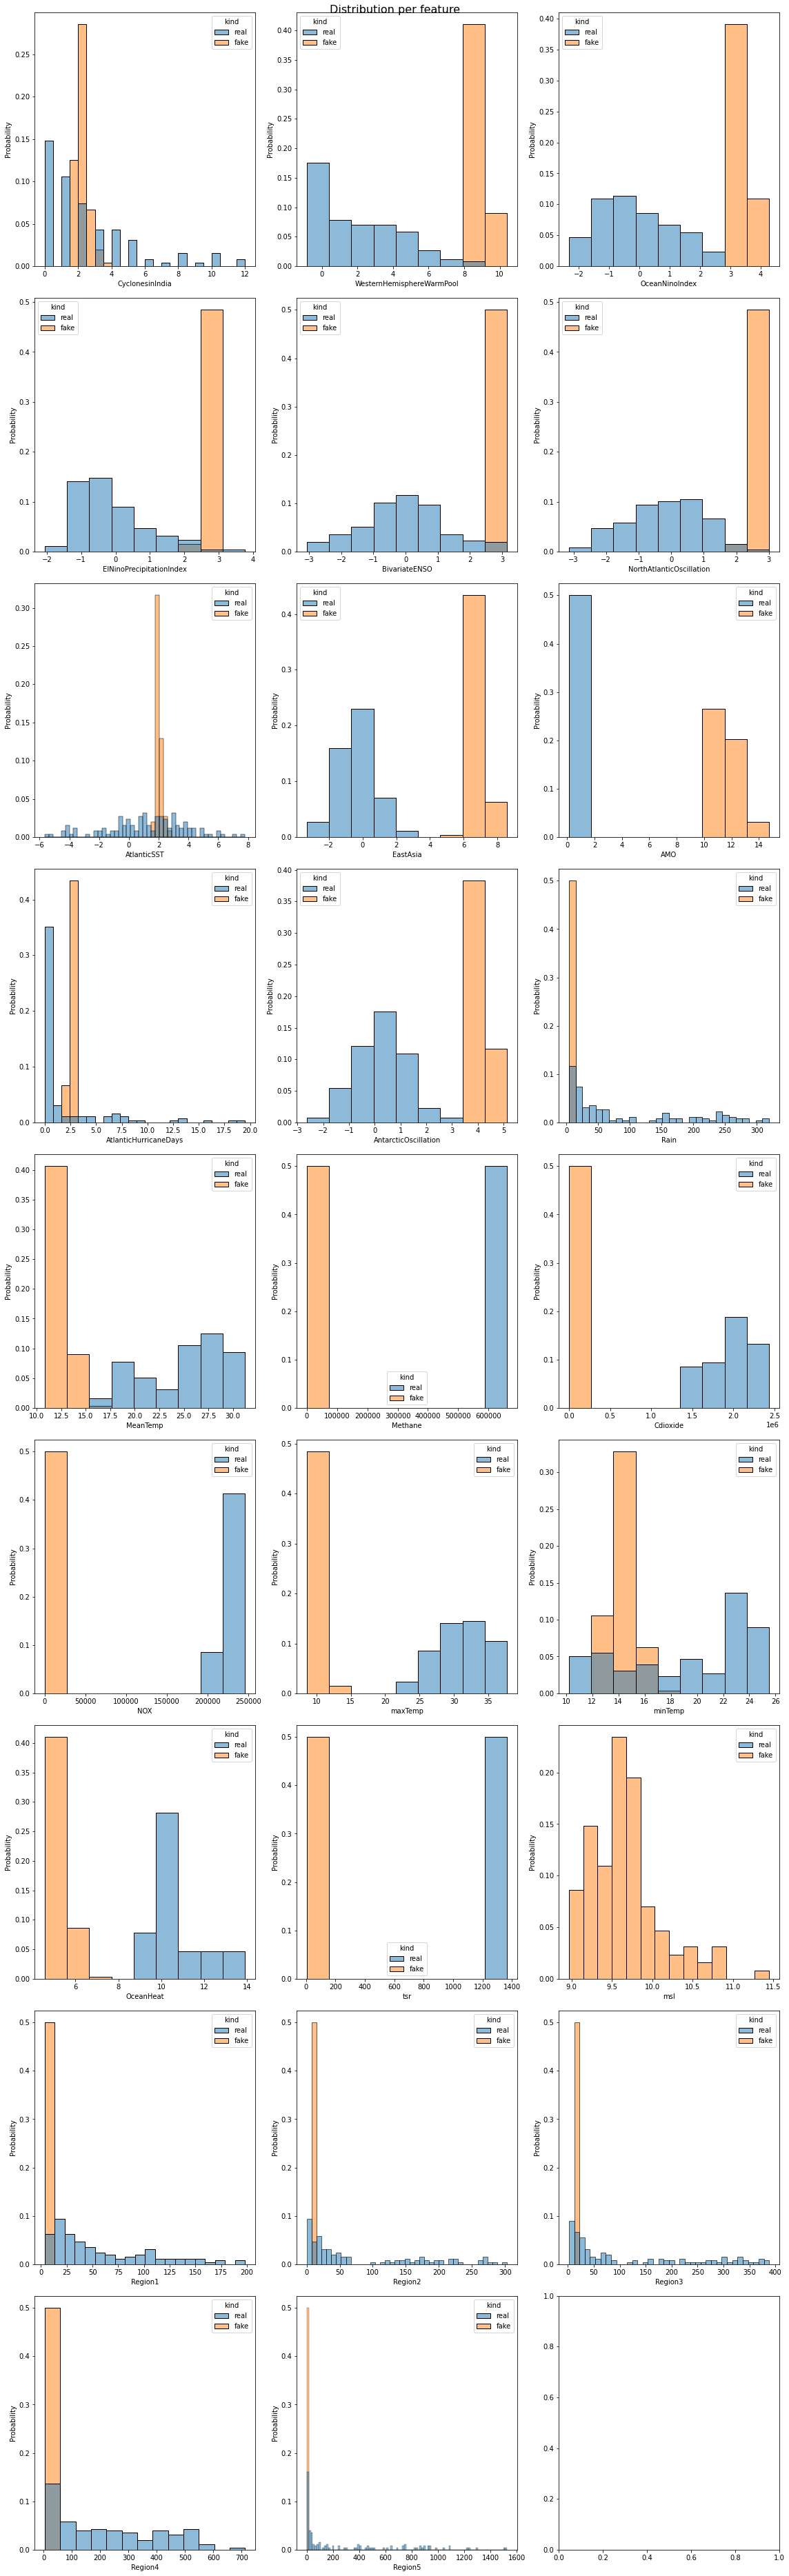

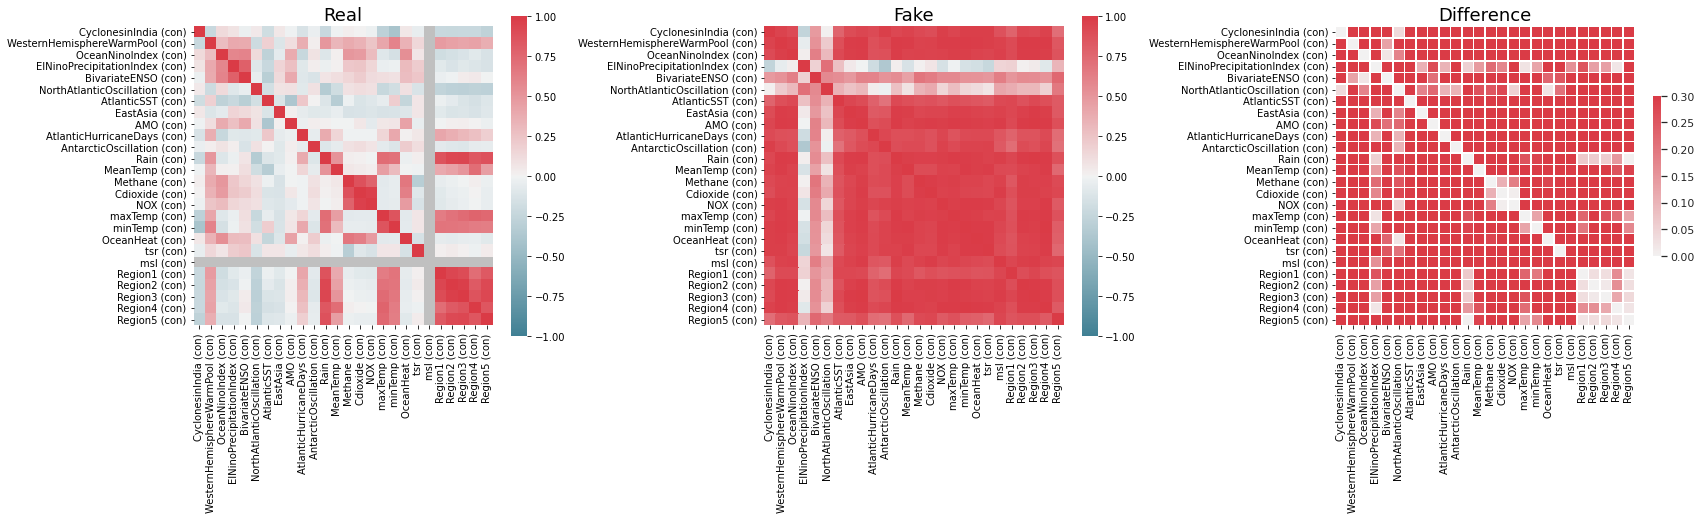

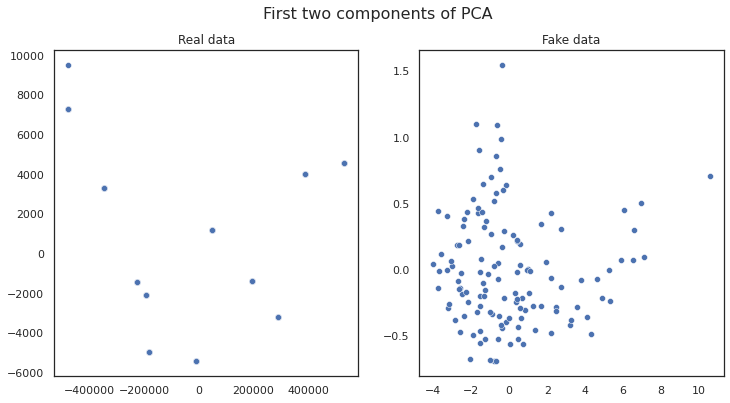

In [ ]:
from table_evaluator import load_data, TableEvaluator
gen_df = pd.read_csv("Generated_sample.csv")
df = pd.read_csv("AllIndiaMonthlyRegional.csv")
gen_df.drop('Unnamed: 0', axis=1, inplace=True)
print(gen_df.columns)
df =df[700:]
df.drop('Date', axis=1, inplace=True)
print(df.shape, gen_df.shape)

# gen_df = gen_df.drop(['Unnamed: 0'],axis=1)
print((df.columns))



table_evaluator =  TableEvaluator(df, gen_df)

table_evaluator.visual_evaluation()

In [ ]:
def generate_latent_points(latent_dim, n_samples):
    x_input = randn(latent_dim * n_samples)
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    x_input = generate_latent_points(latent_dim, n_samples)
    X = generator.predict(x_input)
    y = np.zeros((n_samples, 1))
    
    return X, y

In [ ]:
# generate n real samples with class labels; We randomly select n samples from the real data
def generate_real_samples(n):
    X = df.sample(n)
    y = np.ones((n, 1))
    return X, y

In [ ]:
def define_generator(latent_dim, n_outputs=26):
    # LSTM
    model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
    ])
    return model
    
    


In [ ]:
generator1 = define_generator(10, 9)
generator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_2 (Lambda)           (None, None, 1)           0         
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 64)         8704      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
 lambda_3 (Lambda)           (None, 1)                 0         
                                                                 
Total params: 33,601
Trainable params: 33,601
Non-traina

In [ ]:
import keras
from keras.models import Sequential,Input,Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.advanced_activations import LeakyReLU

def define_discriminator(n_inputs=26):
    # CNN
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),activation='linear',input_shape=(28,28,1),padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D((2, 2),padding='same'))
    model.add(Conv2D(64, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Conv2D(128, (3, 3), activation='linear',padding='same'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(MaxPooling2D(pool_size=(2, 2),padding='same'))
    model.add(Flatten())
    model.add(Dense(128, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))                  
    model.add(Dense(4, activation='softmax'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

    

In [ ]:
discriminator1 = define_discriminator(26)
discriminator1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 28, 28, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 7, 64)         0         
 2D)                                                    

In [ ]:

def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

In [ ]:
# create a line plot of loss for the gan and save to file
def plot_history(d_hist, g_hist):
    # plot loss
    plt.subplot(1, 1, 1)
    plt.plot(d_hist, label='d')
    plt.plot(g_hist, label='gen')
    plt.show()
    plt.close()

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=10000, n_batch=128, n_eval=200):
    # determine half the size of one batch, for updating the  discriminator
    half_batch = int(n_batch / 2)
    d_history = []
    g_history = []
    # manually enumerate epochs
    for epoch in range(n_epochs):
    
      # prepare real samples
      x_real, y_real = generate_real_samples(half_batch)
      #  prepare fake examples
      x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
      # update discriminator
      d_loss_real, d_real_acc = d_model.train_on_batch(x_real, y_real)
      d_loss_fake, d_fake_acc = d_model.train_on_batch(x_fake, y_fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
      # prepare points in latent space as input for the generator
      x_gan = generate_latent_points(latent_dim, n_batch)
      # create inverted labels for the fake samples
      y_gan = np.ones((n_batch, 1))
      # update the generator via the discriminator's error
      g_loss_fake = gan_model.train_on_batch(x_gan, y_gan)
      print('>%d, d1=%.3f, d2=%.3f d=%.3f g=%.3f' % (epoch+1, d_loss_real, d_loss_fake, d_loss,  g_loss_fake))
      d_history.append(d_loss)
      g_history.append(g_loss_fake)
      plot_history(d_history, g_history)
    g_model.save('trained_generated_model.h5')

In [ ]:
# size of the latent space
latent_dim = 10
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# train model

train(generator, discriminator, gan_model, latent_dim)


ValueError: ignored